In [1]:
import pennylane as qml
import pennylane.numpy as np
from matplotlib import pyplot as plt
from pennylane import classical_shadow, shadow_expval, ClassicalShadow

There are two ways of computing expectation values with classical shadows in PennyLane. The first is to return *qml.shadow_expval* directly from the qnode. This has the advantage that it preserves the typical PennyLane syntax and is differentiable.

In [2]:
np.random.seed(666)

H = qml.Hamiltonian([1., 1.], [qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)])

dev = qml.device("default.qubit", wires=2, shots=10000)

@qml.qnode(dev, interface="autograd")
def qnode(x, H):
    qml.Hadamard(0)
    qml.CNOT((0, 1))
    qml.RX(x, wires=0)
    return shadow_expval(H)

x = np.array(0.5, requires_grad=True)

print(qnode(x, H))

1.8657


Each call of *qml.shadow_expval* performs the number of shots dictated by the device. So to avoid unnecessary device executions we can provide a list of observables to *qml.shadow_expval*.


In [3]:
Hs = [H, qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]
print(qnode(x, Hs))

[ 1.8459e+00 -4.8000e-02 -6.0000e-04 -1.2000e-02]


Alternatively, we can compute expectation values by first performing the shadow measurement and then perform classical post-processing using the ClassicalShadow class methods.

In [4]:
dev = qml.device("default.qubit", wires=range(2), shots=10000)
@qml.qnode(dev, interface="autograd")
def qnode(x):
    qml.Hadamard(0)
    qml.CNOT((0,1))
    qml.RX(x, wires=0)
    return classical_shadow(wires=range(2))

bits, recipes = qnode(0.5)
shadow = ClassicalShadow(bits, recipes)
print(bits.shape, recipes.shape)

(10000, 2) (10000, 2)


After recording these $T=1000$ quantum measurements, we can post-process the results to arbitrary local expectation values of Pauli strings. For example, we can compute the expectation value of a Pauli string

In [5]:
print(shadow.expval(Hs))

[ 1.845   0.006  -0.0222 -0.006 ]


### Comparing quantum resources with conventional measurement methods

The goal of the following section is to compare estimation accuracy for a given number of quantum executions with more conventional methods like simultaneously measuring qubit-wise-commuting (qwc) groups. We are going to look at three different cases: The two extreme scenarios of measuring one single and all q-local Pauli strings, as well as the more realistic scenario of measuring a molecular Hamiltonian. We find that for a fix budget of measurements, one is almost never advised to use classical shadows for estimating expectation values.

#### Measuring one single observable

We start with the case of one single measurement. From the analysis above it should be quite clear that in the case of random Pauli measurement in the classical shadows formalism, a lot of quantum resources are wasted as all the measurements that do not match the observable are discarded. This is certainly not what classical shadows were intended for in the first place, but it helps to stress the point of wasted measurements.

In [ ]:
def rmsd(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

n_wires = 10

x = np.arange(2*n_wires, dtype="float64")
def circuit():
    for i in range(n_wires):
        qml.RY(x[i], wires=i)
    for i in range(n_wires-1):
        qml.CNOT(wires=[i, i+1])
    for i in range(n_wires):
        qml.RY(x[i+n_wires], wires=i)
        
obs = qml.PauliX(0) @ qml.PauliZ(3) @ qml.PauliX(6) @ qml.PauliZ(7)

dev_ideal = qml.device("default.qubit", wires=range(n_wires), shots=None)







































exact = qnode_ideal()

/opt/anaconda3/envs/plane/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


We now compare estimating the observable with classical shadows vs the canonical estimation.

In [7]:
finite = []
shadow = []
shotss = range(100, 1000, 100)
for shot in shotss:
    for _ in range(10):
        # repeating the experiment 10 times to obtain averages and standard deviations
        dev = qml.device("default.qubit", wires=range(10), shots=shot)
        
        @qml.qnode(dev, interface="autograd")
        def qnode_finite():
            circuit()
            return qml.expval(obs)
        
        @qml.qnode(dev, interface="autograd")
        def qnode_shadow():
            circuit()
            return qml.shadow_expval(obs)
        
        finite.append(rmsd(qnode_finite(), exact))
        shadow.append(rmsd(qnode_shadow(), exact))
 

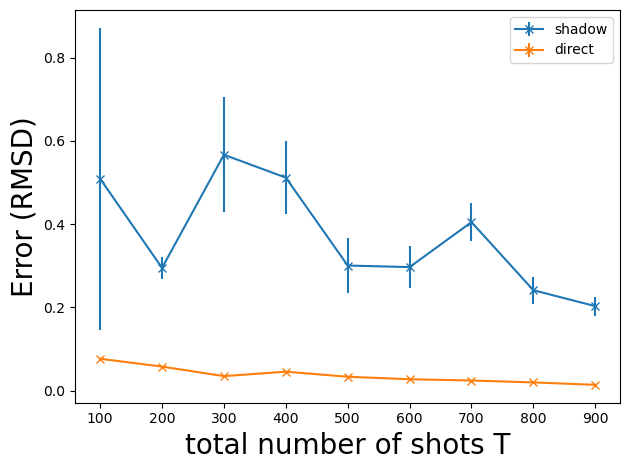

In [8]:
dq = np.array(finite).reshape(len(shotss), 10)
dq, ddq = np.mean(dq, axis=1), np.var(dq, axis=1)
ds = np.array(shadow).reshape(len(shotss), 10)
ds, dds = np.mean(ds, axis=1), np.var(ds, axis=1)

plt.errorbar(shotss, ds, yerr=dds, fmt="x-", label="shadow")
plt.errorbar(shotss, dq, yerr=ddq, fmt="x-", label="direct")
plt.xlabel("total number of shots T", fontsize=20)
plt.ylabel("Error (RMSD)", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()


As we can see, the deviation is consistently smaller by directly measuring the observable since we are not discarding any measurement results.

#### All q-local observables

For the case of measuring all q-local Pauli strings we expect both strategies to yield more or less the same results. In this extreme case, no measurements are discarded in the classical shadow protocol. Let us put that to test. First, we generate a list of all q-local observables for n qubits.

In [9]:
from itertools import product, combinations
from functools import reduce

all_observables = []
n = 5
q = 2

# create all possible combinations of q entries of range(n)
for w in combinations(range(n), q):
    # w = [0, 1], [0, 2], .., [1, 2], [1, 3], .., [n-1, n]
    observables = []
    # Create all combinations of possible Pauli products P_i P_j P_k.... for wires w
    for obs in product(*[[qml.PauliX, qml.PauliY, qml.PauliZ] for _ in range(len(w))]):
        # Perform tensor product (((P_i @ P_j) @ P_k ) @ ....)
        observables.append(reduce(lambda a, b: a @ b, [ob(wire) for ob, wire in zip(obs, w)]))
    all_observables.extend(observables)
    
for observable in all_observables[:10]:
    print(observable)

X(0) @ X(1)
X(0) @ Y(1)
X(0) @ Z(1)
Y(0) @ X(1)
Y(0) @ Y(1)
Y(0) @ Z(1)
Z(0) @ X(1)
Z(0) @ Y(1)
Z(0) @ Z(1)
X(0) @ X(2)


We now group these into qubit-wise-commuting (qwc) groups using *group_observables()* to learn the number of groups. We need this number to make a fair comparison with classical shadows as we allow for only $T/n_{\text{groups}}$ shots per group, such that the total number of shots is the same as for the classical shadow execution. We again compare both approaches.

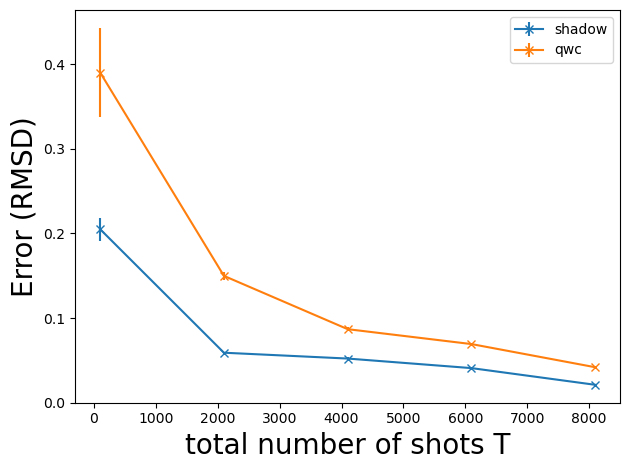

In [10]:
n_groups = len(qml.pauli.group_observables(all_observables))

dev_ideal = qml.device("default.qubit", wires=range(n), shots=None)

x = np.random.rand(n*2)
def circuit():
    for i in range(n):
        qml.RX(x[i], i)

    for i in range(n):
        qml.CNOT((i, (i+1)%n))

    for i in range(n):
        qml.RY(x[i+n], i)

    for i in range(n):
        qml.CNOT((i, (i+1)%n))

@qml.qnode(dev_ideal, interface="autograd")
def qnode_ideal():
    circuit()
    return qml.expval(H)

exact = qnode_ideal()
finite = []
shadow = []
shotss = range(100, 10000, 2000)

for shots in shotss:
    # random Hamiltonian with all q-local observables
    coeffs = np.random.rand(len(all_observables))
    H = qml.Hamiltonian(coeffs, all_observables, grouping_type="qwc")

    @qml.qnode(dev_ideal, interface="autograd")
    def qnode_ideal():
        circuit()
        return qml.expval(H)

    exact = qnode_ideal()

    for _ in range(10):
        dev = qml.device("default.qubit", wires=range(5), shots=shots)

        @qml.qnode(dev, interface="autograd")
        def qnode_finite():
            circuit()
            return qml.expval(H)

        dev = qml.device("default.qubit", wires=range(5), shots=shots*n_groups)
        @qml.qnode(dev, interface="autograd")
        def qnode_shadow():
            circuit()
            return qml.shadow_expval(H)

        finite.append(rmsd(qnode_finite(), exact))
        shadow.append(rmsd(qnode_shadow(), exact))


dq = np.array(finite).reshape(len(shotss), 10)
dq, ddq = np.mean(dq, axis=1), np.var(dq, axis=1)
ds = np.array(shadow).reshape(len(shotss), 10)
ds, dds = np.mean(ds, axis=1), np.var(ds, axis=1)
plt.errorbar(shotss, ds, yerr=dds, fmt="x-", label="shadow")
plt.errorbar(shotss, dq, yerr=ddq, fmt="x-", label="qwc")
plt.xlabel("total number of shots T", fontsize=20)
plt.ylabel("Error (RMSD)", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()



We see that as expected the performance is more or less the same since no quantum measurements are discarded for the shadows in this case. Depending on the chosen random seed there are quantitative variations to this image, but the overall qualitative result remains the same.

No measurements are discarded because the Hamiltonian $H$ contains all possible products of Pauli observables. Thus, $H = \sum_{i<j} P_i P_j$ for $P_i, P_j \in \{X, Y, Z\}$. Then, for every measurement recipe $P_k P_l$ we use, it will always match one observable of $H$, so it will not be discarded: every shot is used to estimate $H$. Note however that, in the previous case where we had to estimate just one observable, every shot in which the recipe did not match the observable exactly was discarded, and thus did not contribute to calculating its expectation value.

#### Molecular Hamiltonians

We now look at the more realistic case of measuring a molecular Hamiltonian. We take H2O as an example. You can find more details on this Hamiltonian in Building molecular Hamiltonians. We start by building the Hamiltonian and enforcing qwc groups by setting grouping_type='qwc'.



In [12]:
symbols = ["H", "O", "H"]
coordinates = np.array([[-0.0399, -0.0038, 0.0], [1.5780, 0.8540, 0.0], [2.7909, -0.5159, 0.0]])
basis_set = "sto-3g"

molecule = qml.qchem.Molecule(symbols, coordinates, basis_name=basis_set)

H, n_wires = qml.qchem.molecular_hamiltonian(
    molecule,
    active_electrons=4,
    active_orbitals=4,
    mapping="bravyi_kitaev",
    method="openfermion",
)

coeffs, obs = H.terms()
H_qwc = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
groups = qml.pauli.group_observables(obs)
n_groups = len(groups)
print(f"number of ops in H: {len(obs)}, number of qwc groups: {n_groups}")
print(f"Each group has sizes {[len(_) for _ in groups]}")

number of ops in H: 193, number of qwc groups: 50
Each group has sizes [4, 6, 4, 7, 4, 7, 3, 6, 7, 8, 4, 4, 4, 13, 8, 6, 3, 4, 4, 3, 4, 4, 2, 7, 3, 8, 2, 3, 2, 2, 4, 3, 2, 3, 2, 2, 2, 2, 5, 2, 2, 1, 2, 2, 2, 2, 4, 2, 2, 1]


We use a pre-prepared Ansatz that approximates the H2O ground state for the given geometry. You can construct this Ansatz by running VQE, see tutorial_vqe. We ran this once on an ideal simulator to get the exact result of the energy for the given Ansatz.

In [14]:
singles, doubles = qml.qchem.excitations(electrons=4, orbitals=n_wires)
hf = qml.qchem.hf_state(4, n_wires)
theta = np.array([ 2.20700008e-02,  8.29716448e-02,  2.19227085e+00,
    3.19128513e+00, -1.35370403e+00,  6.61615333e-03,
    7.40317830e-01, -3.73367029e-01,  4.35206518e-02,
    -1.83668679e-03, -4.59312535e-03, -1.91103984e-02,
    8.21320961e-03, -1.48452294e-02, -1.88176061e-03,
    -1.66141213e-02, -8.94505652e-03,  6.92045656e-01,
    -4.54217610e-04, -8.22532179e-04,  5.27283799e-03,
    6.84640451e-03,  3.02313759e-01, -1.23117023e-03,
    4.42283398e-03,  6.02542038e-03])

res_exact = -74.57076341
def circuit():
    qml.AllSinglesDoubles(weights = theta,
        wires = range(n_wires),
        hf_state = hf,
        singles = singles,
        doubles = doubles)

/opt/anaconda3/envs/plane/lib/python3.13/site-packages/pennylane/ops/op_math/composite.py:209: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in staticmethod() if you want to preserve the old behavior
  return self._math_op(math.vstack(eigvals), axis=0)


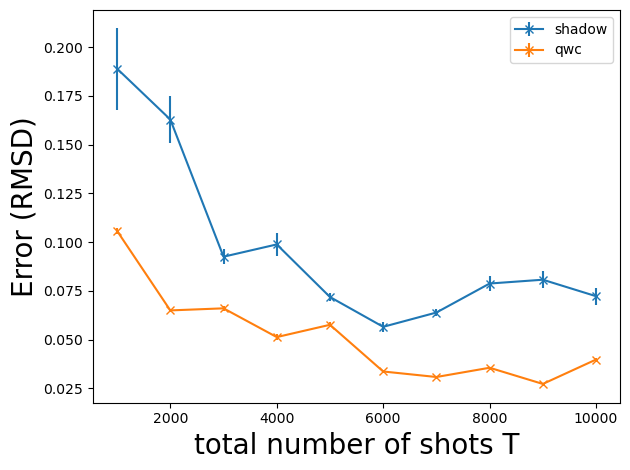

In [15]:
d_qwc = []
d_sha = []

shotss = np.arange(20, 220, 20)

for shots in shotss:
    for _ in range(10):

        # execute qwc measurements
        dev_finite = qml.device("default.qubit", wires=range(n_wires), shots=int(shots))

        @qml.qnode(dev_finite, interface="autograd")
        def qnode_finite(H):
            circuit()
            return qml.expval(H)

        with qml.Tracker(dev_finite) as tracker_finite:
            res_finite = qnode_finite(H_qwc)

        # execute shadows measurements
        dev_shadow = qml.device("default.qubit", wires=range(n_wires), shots=int(shots)*n_groups)
        @qml.qnode(dev_shadow, interface="autograd")
        def qnode():
            circuit()
            return classical_shadow(wires=range(n_wires))

        with qml.Tracker(dev_shadow) as tracker_shadows:
            bits, recipes = qnode()

        shadow = ClassicalShadow(bits, recipes)
        res_shadow = shadow.expval(H, k=1)

        # Guarantuee that we are not cheating and its a fair fight
        assert tracker_finite.totals["shots"] <=  tracker_shadows.totals["shots"]

        d_qwc.append(rmsd(res_finite, res_exact))
        d_sha.append(rmsd(res_shadow, res_exact))


dq = np.array(d_qwc).reshape(len(shotss), 10)
dq, ddq = np.mean(dq, axis=1), np.var(dq, axis=1)
ds = np.array(d_sha).reshape(len(shotss), 10)
ds, dds = np.mean(ds, axis=1), np.var(ds, axis=1)
plt.errorbar(shotss*n_groups, ds, yerr=dds, fmt="x-", label="shadow")
plt.errorbar(shotss*n_groups, dq, yerr=ddq, fmt="x-", label="qwc")
plt.xlabel("total number of shots T", fontsize=20)
plt.ylabel("Error (RMSD)", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

For this realistic example, one is clearly better advised to directly compute the expectation values and not waste precious quantum resources on unused measurements in the classical shadow protocol.

### Conclusion

Overall, we saw that classical shadows always waste unused quantum resources for measurements that are not used, except some extreme cases. For the rare case that the observables that are to be determined are not known before the measurement, classical shadows may prove advantageous.

We have been using a relatively simple approach to qwc grouping, as group_observables() is based on the largest first (LF) heuristic (see largest_first()). There has been intensive research in recent years on optimizing qwc measurement schemes. Similarily, it has been realized by the original authors that the randomized shadow protocol can be improved by what they call derandomization 2. Currently, it seems advanced grouping algorithms are still the preferred choice, as is illustrated and discused in 3.